In [1]:
!pip install --upgrade -q pymc numpy openpyxl graphviz arviz jax jaxlib blackjax pytensor

/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/sre_parse.py:500: RuntimeWarning: coroutine 'Kernel.poll_control_queue' was never awaited
  sourceget = source.get
/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/sre_parse.py:500: RuntimeWarning: coroutine 'IPythonKernel.poll_stopped_queue' was never awaited
  sourceget = source.get


In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from copy import deepcopy

/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/sre_parse.py:428: RuntimeWarning: coroutine 'Kernel.poll_control_queue' was never awaited
  return LITERAL, ord(escape[1])
/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/sre_parse.py:428: RuntimeWarning: coroutine 'IPythonKernel.poll_stopped_queue' was never awaited
  return LITERAL, ord(escape[1])
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Простенькая модель из одного параметра

Поможет разобраться, как самому писать модели

Из гайда: <br>
PyMC has three core functions that map to the traditional Bayesian workflow:

- pm.sample_prior_predictive (docs)
- pm.sample (docs)
- pm.sample_posterior_predictive (docs)
  
**Prior predictive** sampling helps understanding the relationship between the parameter priors and the outcome variable, before any data is observed.<br>

**Sampling** is used to infer the posterior distribution of parameters in a model, conditioned on observed data.<br>

**posterior predictive** sampling can be used to predict new outcomes, conditioned on the posterior parameters.<br>

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


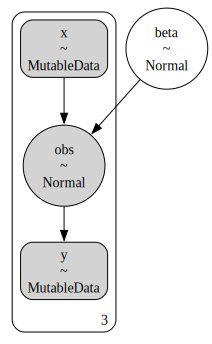

In [13]:
# Следуем гайду:
# https://www.pymc.io/projects/docs/en/v5.7.1/api/generated/pymc.set_data.html


with pm.Model() as model:

    # подкидываем данные в модель:
    x = pm.MutableData('x', [1., 2., 3.])
    y = pm.MutableData('y', [1., 2., 3.])

    # это неизвестный коэффициент
    beta = pm.Normal('beta', 0, 1)
    t = x * beta
    
    # задаём модель в явном виде
    obs = pm.Normal('obs', x * beta, 1, observed=y, shape=x.shape)

    # здесь идёт оценка модели через сэмплер
    # результаты оценки сэмплером будут сохранены в idata
    idata = pm.sample( return_inferencedata=True)


pm.model_to_graphviz(model)

In [14]:
# данные хранятся в объекте модели
model.x.get_value()

array([1., 2., 3.])

In [15]:
model.y.get_value()

array([1., 2., 3.])

In [16]:
# А вот результаты сэмплера лежат в idata
# отображаем оценку неизвестного коэффициента бета
az.summary(idata, var_names=["beta"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.938,0.253,0.454,1.405,0.006,0.004,1749.0,2848.0,1.0


In [17]:
# Можно получить более детальную информацию об оценке коэффициента
# Оценку запустили четыре раза. Ниже распределение параметра в каждом запуске сэмплера
beta_distribution = idata.posterior.beta.values

print(beta_distribution)

print ("\n\n")
print ("Медианная оценка бета в каждом из 4 chains pymc")
print (beta_distribution.mean(axis=1))

[[0.65673679 0.77914684 0.59512944 ... 1.05040032 1.05040032 1.29754696]
 [0.95171734 1.00723153 1.0306599  ... 0.49335468 1.32054732 1.04369767]
 [0.60529655 0.63248671 0.9639087  ... 0.7425792  0.63163483 0.54591982]
 [1.44205716 1.40491647 1.26233626 ... 1.11183037 0.66311764 1.23168353]]



Медианная оценка бета в каждом из 4 chains pymc
[0.94459262 0.95104842 0.9329893  0.92420917]


In [18]:
# делаем предсказание на трейне

# так как данные для Х и Y хранятся внутри класса "model", то при инференсе я бы делал копию модели
with deepcopy(model):
    idata_train = pm.sample_posterior_predictive(idata)

# результат:
idata_train.posterior_predictive['obs'].mean(('chain', 'draw')).values

Sampling: [obs]


array([0.949511  , 1.84982657, 2.83082962])

In [19]:
# делаем предсказание на трейне
model2 = deepcopy(model)

# так как данные для Х и Y хранятся внутри класса "model", то при инференсе я бы делал копию модели
with model2:
    # здесь меняем параметры внутри модели
    pm.set_data({"x": [4,5,6,8,9,19,11]})
    idata_test = pm.sample_posterior_predictive(idata,)

# предсказания на трейн датасете
idata_test.posterior_predictive['obs'].mean(('chain', 'draw')).values

Sampling: [obs]


array([ 3.75764793,  4.70462142,  5.6133929 ,  7.51784329,  8.45349052,
       17.80102758, 10.32514972])

## Попробуем предсказать инфляцию с помощью BVAR



In [20]:
# Идём по гайду:
# https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html

# Данные вот отсюда:
# https://github.com/european-central-bank/BEAR-toolbox/tree/master/tbx/replications

# BEAR
df_full = pd.read_excel("data_economic/data_.xlsx",index_col=0)

# проверяем, что в колонках только числовые переменные - '1974q1, ... ' - отправили в индекс
df_full

,DOM_GDP,DOM_CPI,STN,Oil
1974q1,-0.449406,7.383696,9.32,4.60
1974q2,0.354139,8.072929,11.25,15.50
1974q3,-1.542295,8.349771,12.09,13.00
1974q4,-1.113763,8.442405,9.35,11.50
1975q1,-2.588827,7.914478,6.30,11.70
...,...,...,...,...
2013q4,1.950169,0.842545,0.09,109.07
2014q1,1.437325,1.546078,0.07,110.50
2014q2,1.822617,1.514121,0.09,106.15
2014q3,1.930290,1.283037,0.09,110.89


In [11]:
### Define a helper function that will construct our autoregressive step for the marginal contribution of each lagged
### term in each of the respective time series equations
def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
    # эта функция добавляет авторегрессионные лаги для каждой переменной
    ars = []
    for j in range(n_eqs):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[j, i] * df.values[n_lags - (i + 1) : -(i + 1)], axis=-1)
                for i in range(n_lags)
            ],
            axis=0,
        )
        ars.append(ar)
    beta = pm.math.stack(ars, axis=-1)

    return beta


### Make the model in such a way that it can handle different specifications of the likelihood term
### and can be run for simple prior predictive checks. This latter functionality is important for debugging of
### shape handling issues. Building a VAR model involves quite a few moving parts and it is handy to
### inspect the shape implied in the prior predictive checks.
def make_model(n_lags, df, priors, n_train: int,  mv_norm=True, prior_checks=True):

    df = df.iloc[:n_train]
    n_eqs = df.shape[1]
    
    coords = {
        "lags": np.arange(n_lags) + 1,
        "equations": df.columns.tolist(),
        "cross_vars": df.columns.tolist(),
        "time": [x for x in df.index[n_lags:]],
    }

    with pm.Model(coords=coords) as model:
        lag_coefs = pm.Normal(
            "lag_coefs",
            mu=priors["lag_coefs"]["mu"],
            sigma=priors["lag_coefs"]["sigma"],
            dims=["equations", "lags", "cross_vars"],
        )

        alpha = pm.Normal(
            "alpha", mu=priors["alpha"]["mu"], sigma=priors["alpha"]["sigma"], dims=("equations",)
        )

        data_obs = pm.Data("data_obs", 
                           df.iloc[n_lags:],  
                           mutable=True)


        betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df)
        betaX = pm.Deterministic(
            "betaX",
            betaX,
            dims=[
                "time",
            ],
        )

        mean = alpha + betaX

        if mv_norm:
            n = df.shape[1]
            ## Under the hood the LKJ prior will retain the correlation matrix too.
            noise_chol, _, _ = pm.LKJCholeskyCov(
                "noise_chol",
                eta=priors["noise_chol"]["eta"],
                n=n,
                sd_dist=pm.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"]),
            )
            obs = pm.MvNormal(
                "obs", mu=mean, chol=noise_chol, observed=data_obs, dims=["time", "equations"]
            )
        else:
            ## This is an alternative likelihood that can recover sensible estimates of the coefficients
            ## But lacks the multivariate correlation between the timeseries.
            sigma = pm.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
            obs = pm.Normal(
                "obs", mu=mean, sigma=sigma, observed=data_obs, dims=["time", "equations"]
            )

        ## Здесь как раз рассчитываем саму модель
        ## на скорость оценки модели влияют три параметра draws, chains и tune
        idata = pm.sample(**priors['sampler_params'])      
        
    return model, idata


/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/deep_env310/lib/python3.10/site-packages/pymc/sampling/jax.py:383: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  lag_coefs: shape=(4, 3, 4)
      alpha: shape=(4,)
noise_chol_cholesky-cov-packed__: shape=(10,)
 noise_chol: shape=(10,)


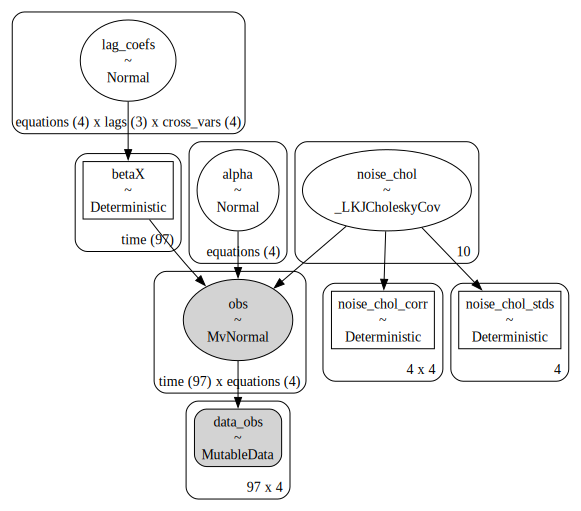

In [12]:
n_lags = 3

priors = {
    "lag_coefs": {"mu": 0.3, "sigma": 1},
    "alpha": {"mu": 15, "sigma": 5},
    "noise_chol": {"eta": 1, "sigma": 1},
    "noise": {"sigma": 1},
    # 
    'sampler_params': {'chains': 2, 'draws': 200, 'tune': 200, 'nuts_sampler': 'blackjax'},
}



# функция оценит нашу модель
# и по скорости этой функции можно для себя оценить, как много времени нужно для тренировки баесовских моделей...
model, idata = make_model(n_lags, df_full, priors, n_train = 100)

# печатаем сколько параметров оценивали
for rv, shape in model.eval_rv_shapes().items():
    print(f"{rv:>11}: shape={shape}")

 
# требует установки graphviz
pm.model_to_graphviz(model)

In [13]:
# Здесь наша оценка коэффициентов модели
az.summary(idata, var_names=["alpha", "lag_coefs", "noise_chol_corr"])


/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/deep_env310/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[DOM_GDP],1.566,0.427,0.739,2.327,0.018,0.013,566.0,365.0,1.00
alpha[DOM_CPI],0.485,0.189,0.190,0.872,0.008,0.006,550.0,308.0,1.00
alpha[STN],-0.796,0.525,-1.718,0.146,0.019,0.014,779.0,258.0,1.00
alpha[Oil],2.355,1.539,-0.059,5.689,0.065,0.060,605.0,350.0,1.01
"lag_coefs[DOM_GDP, 1, DOM_GDP]",0.902,0.106,0.710,1.101,0.005,0.004,397.0,317.0,1.00
...,...,...,...,...,...,...,...,...,...
"noise_chol_corr[2, 3]",0.048,0.109,-0.193,0.223,0.004,0.006,614.0,235.0,1.01
"noise_chol_corr[3, 0]",0.002,0.099,-0.191,0.166,0.004,0.004,729.0,289.0,1.00
"noise_chol_corr[3, 1]",0.268,0.089,0.095,0.415,0.003,0.003,764.0,337.0,1.00
"noise_chol_corr[3, 2]",0.048,0.109,-0.193,0.223,0.004,0.006,614.0,235.0,1.01


In [25]:
import pymc as pm

def create_my_model(data, n_train: int, n_lags: int, priors, sampler_params, mv_norm = True):

    if n_train>0:
        df = data.iloc[:n_train].copy(deep=True)
    else:
        df = data.copy(deep=True)
            

    n_obs = df.shape[0]    
    n_eq = df.shape[1] # Number of equations equal to number of columns

    coords = {
        "lags": np.arange(n_lags) + 1,
        "equations": df.columns.tolist(),
        "cross_vars": [f"var_{x}" for x in df.columns.tolist()],
        "time": [i for i in df.index[n_lags:]],
    }


    with pm.Model(coords=coords) as model:

        # N_eq equations, each with N_lags and N_eq variables (to which lags will be applied)        
        lag_coefs = pm.Normal(
            "lag_coefs",
            mu=priors["lag_coefs"]["mu"],
            sigma=priors["lag_coefs"]["sigma"],
            dims=["equations", "lags", "cross_vars"],
        )
    
        alpha = pm.Normal(
            "alpha", mu=priors["alpha"]["mu"], sigma=priors["alpha"]["sigma"], dims=("equations",)
        )

        data_obs = pm.Data(f"data_obs", 
                           df.iloc[n_lags:].values,  
                           mutable=True)
        
        data_lags = {}
        n_obs = df.shape[0]
        for i in range(n_lags):
            dl = pm.Data(f"data_lag{i+1}", 
                         df.iloc[n_lags-i-1:n_obs-i-1].values,  
                         mutable=True)

            print(dl.shape.eval())
            data_lags[i] = dl
        
        # Create VAR equations
        var = []
        # returns tensor with dimension [n_train_obs - n_lags]
        for j in range(n_eq):
            ar = pm.math.sum(
                [
                pm.math.sum(lag_coefs[j, i] * data_lags[i], axis=-1) 
                    for i in range(n_lags)
                ], axis=0)
            print ('ar_eq:', ar.shape.eval())
            var.append(ar)
    
        # beta multiplied by X
        # shape = [n_train_obs - n_lags, n_eq]
        betaX = pm.math.stack(var, axis=-1)
    
        print ('betax:', betaX.shape.eval())

        mean = alpha + betaX

        mean = pm.Deterministic(
            "alpha+betaX",
            mean
        )        
        print ('mean:', mean.shape.eval())
    
        if mv_norm:
            # https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.LKJCholeskyCov.html
            chol, _, _ = pm.LKJCholeskyCov(
                "noise_chol",
                eta=priors["noise_chol"]["eta"],
                n=n_eq,
                sd_dist=pm.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"],shape=n_eq), 
            )
            
            # print ("noise_chol", chol.shape.eval())

            # obs = pm.MvNormal(
            #     "obs", mu=mean, chol=chol, observed=data_obs)

            vals_raw = pm.Normal("vals_raw", mu=mean, sigma=1)
            vals = pm.math.dot(vals_raw, chol)
            obs = pm.Normal("obs", mu=vals, sigma=0.0001, observed=data_obs, shape=data_lags[i].shape)
            print ('obs', obs.shape.eval())
        
        else:
            ## This is an alternative likelihood that can recover sensible estimates of the coefficients
            ## But lacks the multivariate correlation between the timeseries.
            sigma = pm.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
                
            print ('sigma:', sigma.shape.eval())
            print ('data_obs:', data_obs.shape.eval())        
            obs = pm.Normal(
                "obs", mu=mean, sigma=sigma, observed=data_obs)

        idata = None
        idata = pm.sample(**sampler_params)     
        
    return model, idata


[118   4]
[118   4]
ar_eq: [118]
ar_eq: [118]
ar_eq: [118]
ar_eq: [118]
betax: [118   4]
mean: [118   4]
obs [118   4]


/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/deep_env310/lib/python3.10/site-packages/pymc/sampling/jax.py:383: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  lag_coefs: shape=(4, 2, 4)
      alpha: shape=(4,)
noise_chol_cholesky-cov-packed__: shape=(10,)
 noise_chol: shape=(10,)
   vals_raw: shape=(118, 4)


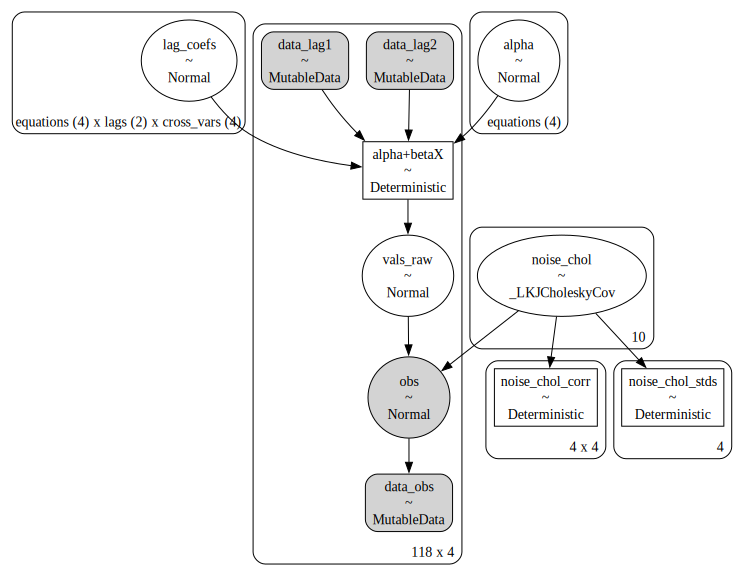

In [26]:
priors = {
    "lag_coefs": {"mu": 0.3, "sigma": 1.0},
    "alpha": {"mu": 15.0, "sigma": 5.0},
    "noise_chol": {"eta": 1.0, "sigma": 1.0},
    "noise": {"sigma": 1.0},

}

sampler_params = {'chains': 4, 'draws': 10000, 'tune': 10000, 'nuts_sampler': 'blackjax'}

n_lags = 2 # number of lags
n_train = 120 # number of observations to user for training, you can use negative value to train on full dataset
mv_norm = True # Use multivariate normal distribution


model, idata = create_my_model(df_full, 
                               n_train = n_train, 
                               n_lags = n_lags, 
                               priors = priors, sampler_params = sampler_params, mv_norm = mv_norm) 


# печатаем сколько параметров оценивали
for rv, shape in model.eval_rv_shapes().items():
    print(f"{rv:>11}: shape={shape}")

pm.model_to_graphviz(model)

In [27]:
# Здесь наша оценка коэффициентов модели
az.summary(idata, var_names=["alpha", "lag_coefs", "noise_chol_corr"])


/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/deep_env310/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[DOM_GDP],15.008,0.578,14.203,15.804,0.289,0.221,4.0,12.0,3.79
alpha[DOM_CPI],14.783,0.608,14.091,15.452,0.304,0.233,4.0,13.0,3.23
alpha[STN],15.230,0.592,14.244,15.822,0.296,0.227,4.0,11.0,3.75
alpha[Oil],14.792,0.541,14.228,15.618,0.271,0.207,4.0,12.0,3.18
"lag_coefs[DOM_GDP, 1, var_DOM_GDP]",0.211,0.495,-0.499,0.823,0.247,0.189,4.0,13.0,3.51
"lag_coefs[DOM_GDP, 1, var_DOM_CPI]",0.475,0.347,0.144,1.051,0.174,0.133,4.0,17.0,3.47
"lag_coefs[DOM_GDP, 1, var_STN]",0.575,0.699,-0.278,1.267,0.349,0.268,4.0,12.0,3.39
"lag_coefs[DOM_GDP, 1, var_Oil]",0.406,0.402,-0.234,0.838,0.201,0.154,4.0,13.0,4.22
"lag_coefs[DOM_GDP, 2, var_DOM_GDP]",0.722,0.351,0.151,1.060,0.176,0.135,4.0,13.0,3.52
"lag_coefs[DOM_GDP, 2, var_DOM_CPI]",0.288,0.464,-0.177,0.845,0.232,0.178,4.0,12.0,3.51


In [35]:
# Если тренировались не на всех данных, то можем посмотреть экстраполяцию на будущее
# Т.е. построили модель на 140 точек из 160, поэтому последние 20 точек можно предсказать,
# чтобы проверить качество модели

df_test = df_full.copy(deep=True)

with deepcopy(model):
    print ("Count lags:", n_lags)
    n_obs = df_test.shape[0]
    n_eq = df_test.shape[1]

    for i in range(n_lags):
        pm.set_data({f"data_lag{i+1}": df_test.iloc[n_lags-i-1:n_obs-i-1].values})
    
    idata_test = pm.sample_posterior_predictive(idata, random_seed=44, predictions=True)



Sampling: [obs]


Count lags: 2


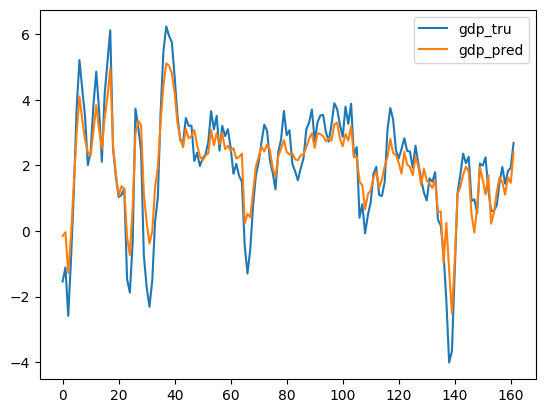

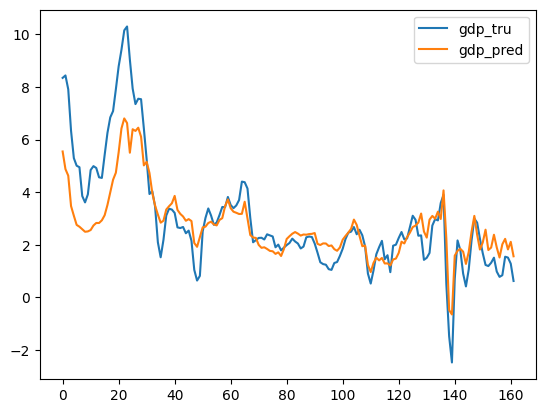

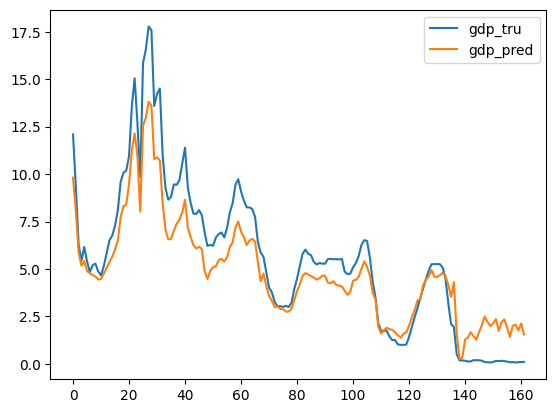

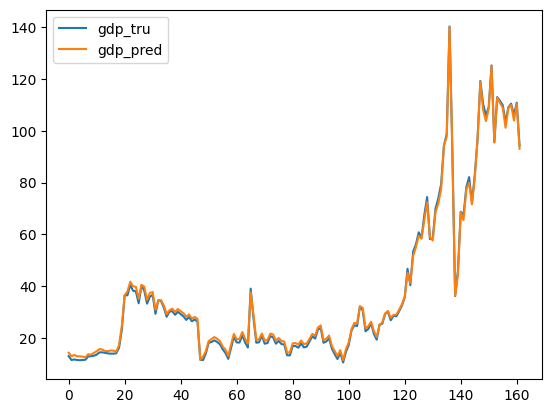

In [36]:
results = idata_test.predictions['obs'].mean(('chain', 'draw')).values

for i, col in enumerate(df_full.columns):
    df_preds = pd.DataFrame({'gdp_tru': df_full[col].values[n_lags:], # первые два наблюдения съели лаги
                             'gdp_pred': results[:,i] # первая перемення gdp
                            })
    
    df_preds.plot()

In [37]:
# сделаем фит на всех данных
model, idata = create_my_model(df_full, 
                               n_train = -1, 
                               n_lags = n_lags, 
                               priors = priors, 
                               sampler_params = sampler_params, 
                               mv_norm = mv_norm) 

# а потом предскажем одну точку вперёд
print ("Model fit done")

[162   4]
[162   4]
ar_eq: [162]
ar_eq: [162]
ar_eq: [162]
ar_eq: [162]
betax: [162   4]
mean: [162   4]
obs [162   4]


/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/deep_env310/lib/python3.10/site-packages/pymc/sampling/jax.py:383: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Model fit done


In [38]:
# Теперь предскажем одно новую точку, используя самые послдение данные
# вот эту штуку нужно зафигачить в цикл, чтобы предсказать по одному наблюдению вперёд
df = df_full.copy(deep=True)

with deepcopy(model):
    print ("Count lags:", n_lags)
    
    n_obs = df.shape[0]
    n_eq = df.shape[1]

    for i in range(n_lags):
        # первый лаг должен взять самое последнее наблюдение
        tt = df_test.iloc[n_obs-i-1:n_obs-i]
        pm.set_data({f"data_lag{i+1}": tt})
        

    id_step = pm.sample_posterior_predictive(idata, random_seed=44, predictions=True)

prediction = id_step.predictions['obs'].mean(('chain', 'draw')).values


pd.DataFrame(prediction, columns  = df_full.columns, index= ['forecast'])

Sampling: [obs, vals_raw]


Count lags: 2


,DOM_GDP,DOM_CPI,STN,Oil
forecast,2.818156,0.645168,2.948801,18.87883
